## Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация
Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing)
Обернуть его в Dataloader
Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели
train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import torchmetrics
import torch.nn.functional as F

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
train_dataset = sklearn.datasets.fetch_california_housing()
train_dataset

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [3]:
data = train_dataset.data
target = train_dataset.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=13)

In [5]:
# сделаем стандарт-скейлер так как это задача регрессии и мин-макс скейлер будет хуже работать

scaler = MinMaxScaler()
# scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
class MyOwnCH(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    
train_dataset = MyOwnCH(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = MyOwnCH(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=0)

In [8]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2 * hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2 * hidden_dim)
        self.fc2 = Perceptron(2 * hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [9]:
def model_comparing(model, optimizer):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(30):
        
        model.train()
        
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_test = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [10]:
def metrics_view(r2_train_list, r2_test_list, optim):
    
    epoch = np.arange(1,31,1)
    y_train = r2_train_list
    y_test = r2_test_list
    plt.plot(epoch, y_train, label='R2_train')
    plt.plot(epoch, y_test, label='R2_test')
    plt.title(f"{optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

In [11]:
model = FeedForward(8, 400)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.0)
r2_train_SGD, r2_test_SGD = model_comparing(model, optimizer)

FeedForward(
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=8, out_features=800, bias=True)
  )
  (dp1): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (dp2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Perceptron(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
)
Epoch 1: r2_train = -0.9406943321228027, r2_test = -0.1304394006729126
Epoch 2: r2_train = -0.3069474697113037, r2_test = 0.05730605125427246
Epoch 3: r2_train = -0.12380874156951904, r2_test = 0.14326024055480957
Epoch 4: r2_train = -0.02467477321624756, r2_test = 0.23501914739608765
Epoch 5: r2_train = 0.047100841999053955, r2_test = 0.2582349181175232
Epoch 6: r2_train = 

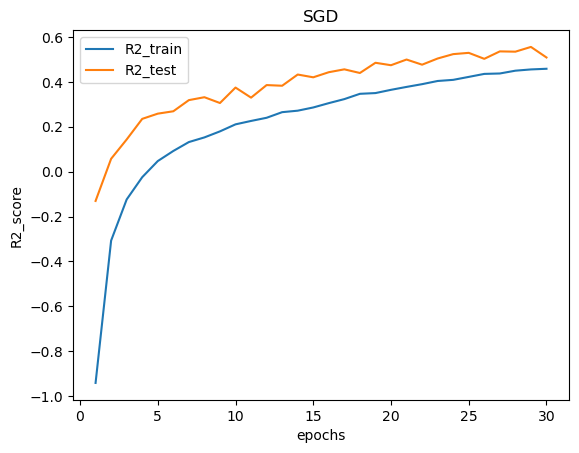

In [12]:
metrics_view(r2_train_SGD, r2_test_SGD, 'SGD')

In [13]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
r2_train_RMSprop, r2_test_RMSprop = model_comparing(model, optimizer)

Epoch 1: r2_train = 0.2416805624961853, r2_test = 0.562088131904602
Epoch 2: r2_train = 0.517013430595398, r2_test = 0.637454628944397
Epoch 3: r2_train = 0.582892894744873, r2_test = 0.6233905553817749
Epoch 4: r2_train = 0.6086714863777161, r2_test = 0.7013778686523438
Epoch 5: r2_train = 0.6305872201919556, r2_test = 0.7019361257553101
Epoch 6: r2_train = 0.6534202098846436, r2_test = 0.6574167609214783
Epoch 7: r2_train = 0.6578809022903442, r2_test = 0.6805139183998108
Epoch 8: r2_train = 0.6678227186203003, r2_test = 0.7302656769752502
Epoch 9: r2_train = 0.6705279350280762, r2_test = 0.6748164296150208
Epoch 10: r2_train = 0.677571177482605, r2_test = 0.7375180721282959
Epoch 11: r2_train = 0.6868409514427185, r2_test = 0.7382321357727051
Epoch 12: r2_train = 0.6860595345497131, r2_test = 0.7464953064918518
Epoch 13: r2_train = 0.6904870867729187, r2_test = 0.7305741310119629
Epoch 14: r2_train = 0.6963828206062317, r2_test = 0.7410649061203003
Epoch 15: r2_train = 0.69572234153

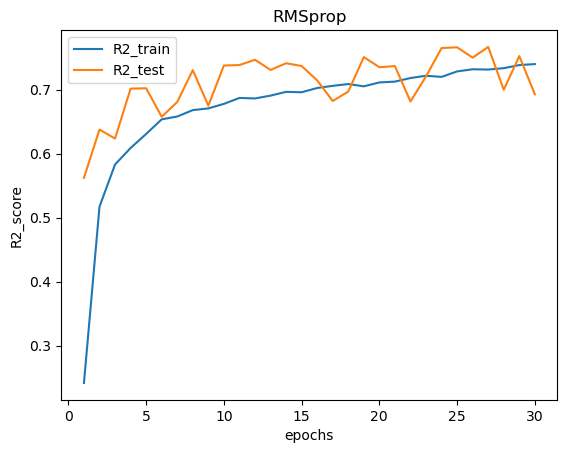

In [14]:
metrics_view(r2_train_RMSprop, r2_test_RMSprop, 'RMSprop')

In [15]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
r2_train_Adam, r2_test_Adam = model_comparing(model, optimizer)

Epoch 1: r2_train = 0.1212235689163208, r2_test = 0.46824777126312256
Epoch 2: r2_train = 0.45365822315216064, r2_test = 0.5965794324874878
Epoch 3: r2_train = 0.5442875027656555, r2_test = 0.6436000466346741
Epoch 4: r2_train = 0.5878350734710693, r2_test = 0.6738438606262207
Epoch 5: r2_train = 0.618703305721283, r2_test = 0.6966396570205688
Epoch 6: r2_train = 0.6308107376098633, r2_test = 0.7018783092498779
Epoch 7: r2_train = 0.6550837755203247, r2_test = 0.7213921546936035
Epoch 8: r2_train = 0.660570502281189, r2_test = 0.7193424105644226
Epoch 9: r2_train = 0.6707139611244202, r2_test = 0.7304389476776123
Epoch 10: r2_train = 0.6691001653671265, r2_test = 0.6990980505943298
Epoch 11: r2_train = 0.6782147288322449, r2_test = 0.6434345245361328
Epoch 12: r2_train = 0.6783854365348816, r2_test = 0.7427142858505249
Epoch 13: r2_train = 0.6899983286857605, r2_test = 0.6926295757293701
Epoch 14: r2_train = 0.6956818103790283, r2_test = 0.7548363208770752
Epoch 15: r2_train = 0.704817

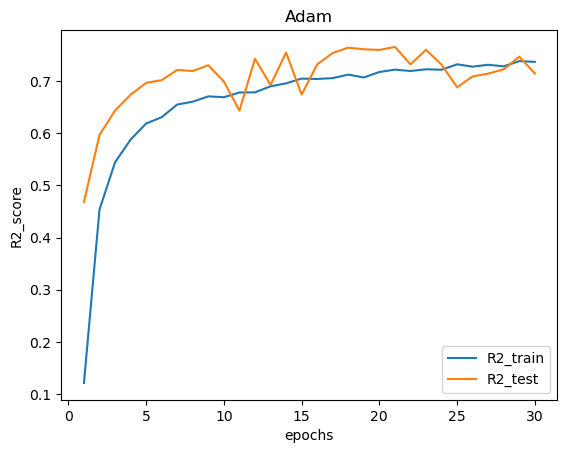

In [16]:
metrics_view(r2_train_Adam, r2_test_Adam, 'Adam')

In [17]:
#Сравнение метрик
metrics_result = pd.DataFrame([{'r2_train': r2_train_SGD[-1].item(), 'r2_test': r2_test_SGD[-1].item()},
                               {'r2_train': r2_train_RMSprop[-1].item(), 'r2_test': r2_test_RMSprop[-1].item()},
                               {'r2_train': r2_train_Adam[-1].item(), 'r2_test': r2_test_Adam[-1].item()},
                              ],
                              index = ['SGD', 'RMSprop', 'Adam'], 
                              columns = ['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
Adam,0.736865,0.714655
RMSprop,0.739708,0.692544
SGD,0.458092,0.508398


Вывод: Алгоримт SGD долго сходится - но достаточно стабильно. Ему требуется больше эпох, чтобы прийти к значениям метрик, которые достигаются другими алгоритмами значительно быстрее.

Алгоритмы Adam и RMSprop сходятся примерно одинаково. И быстрее чем SGD.